In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
from iso8601 import parse_date

import pprint
pp = pprint.PrettyPrinter().pprint

import sys

In [3]:
from satbazaar import db
from satbazaar import schedulers
from satbazaar import client

In [4]:
# script 'get-stations.py' creates this file
stations = db.load_stations()

# script 'get-satellites.py' creates both files
satellites = db.load_satellites()

In [5]:
gs = stations['KB9JHU']

# script 'generate-allpasses.py' generates the database of sat-gs pass predictions
passes = db.getpasses(gs=gs['name'], start='2018-07-11', end='2018-07-11 04:00')
duration = (passes.end() - passes.begin()).total_seconds()
print('duration:       ', duration)

maxtree = passes.copy()
maxtree.merge_overlaps()
total = 0.0
for i in maxtree:
    total += (i.end - i.begin).total_seconds()
print('total pass time:', total)

duration:        14317.007544
total pass time: 14061.390043


In [6]:
def do_plot():
    fig, ax = plt.subplots(figsize=(8, 4))

    ax.bar(names, busys)

    labels = ax.get_xticklabels()
    plt.setp(labels, rotation=20)
    
    print('{:20s} {:>5s}  {:>5s}'.format('Scheduler', 'busy', 'eff'))
    for n, b in zip(names, busys):
        print('{:20s} {:5.1f}  {:5.1f}'.format(n, 100*b/duration, 100*b/total))

In [7]:
def plot_result(c, name):
    # collect satellite names
    sats = set([p.data['job']['tle0'] for p in c.calendar])
    sats = list(sats)
    sats.sort()
    sats.reverse()
    #index is used as y-offset


    # sats simultaneously overhead
    start = c.calendar.begin()  #parse_date('2018-07-11')
    end = c.calendar.end()  #parse_date('2018-07-11 04:00')

    total_minutes = (end - start).total_seconds()/60
    steps = [start + timedelta(minutes=x) for x in range(int(total_minutes))]
    num = []
    for t in steps:
        passes = c.calendar[t]
        num.append(len(passes))

        
    #plt.close('all')
    fig = plt.figure(figsize=(20, 8))

    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[8, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)

    ax0.xaxis_date()
    ax0.set_ylim((0.9, 2.0))

    from itertools import cycle, islice
    colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

    for p in c.calendar:
        sat = p.data['job']['tle0']
        idx = sats.index(sat)
        ax0.plot(
            (p.begin, p.end),
            2*[1],
            '-|',
            color=colors[idx%len(colors)],
        )
        ax0.text(
            p.begin + (p.end - p.begin)/2,
            1.0,
            ' ' + sat,
            rotation=90,
            ha='center',
            va='bottom',
            fontsize='large',
        )

    #ax0.set_yticks(range(len(sats)))
    #ax0.set_yticklabels(sats)
    ax0.set_title('{}\n{}'.format(name, c))
    ax0.grid(True, axis='x')


    # lower plot
    ax1.plot(steps, num)
    ax1.xaxis_date()
    ax1.grid(True, axis='x')
    ax1.set_ylabel('# visible sats', fontsize='xx-large')

    plt.tight_layout()
    fig.autofmt_xdate()

    #plt.savefig('kb9jhu.png', dpi=150, bbox_inches='tight')

Scheduler             busy    eff
RandomScheduler       68.8   70.1
FirstScheduler        80.0   81.4
LastScheduler         79.9   81.4
DurationScheduler     74.0   75.3
EndStartScheduler     80.0   81.4


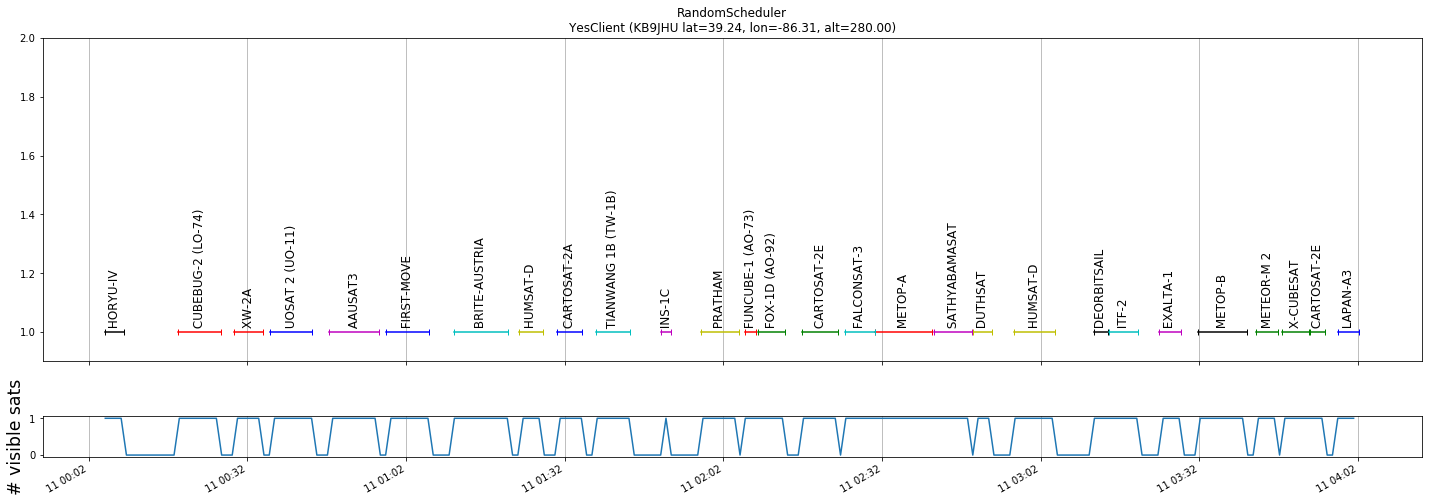

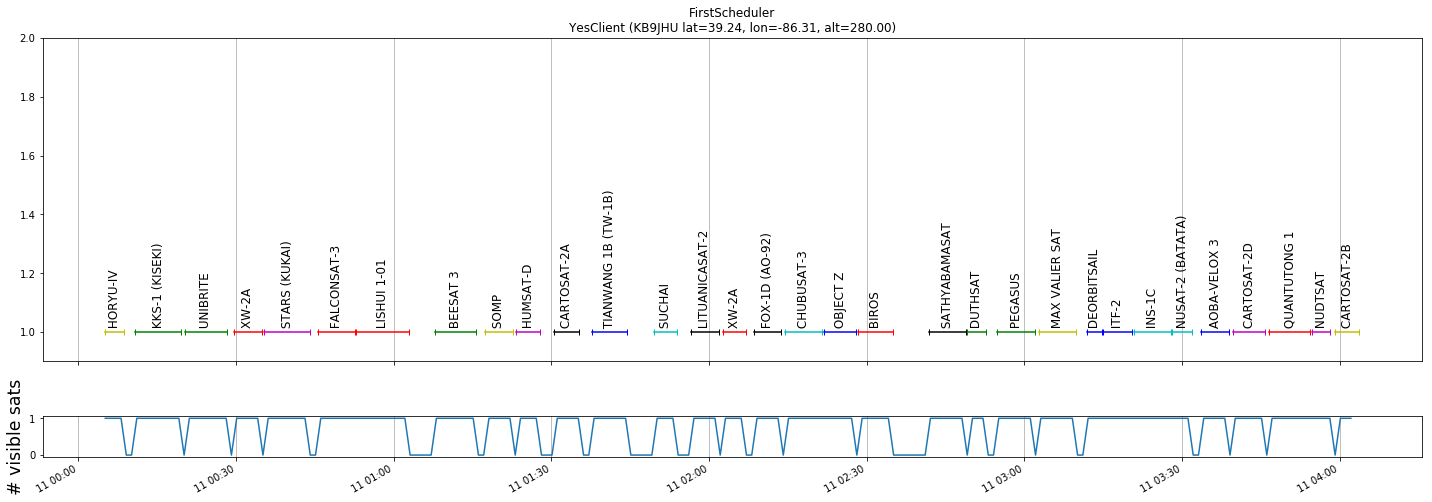

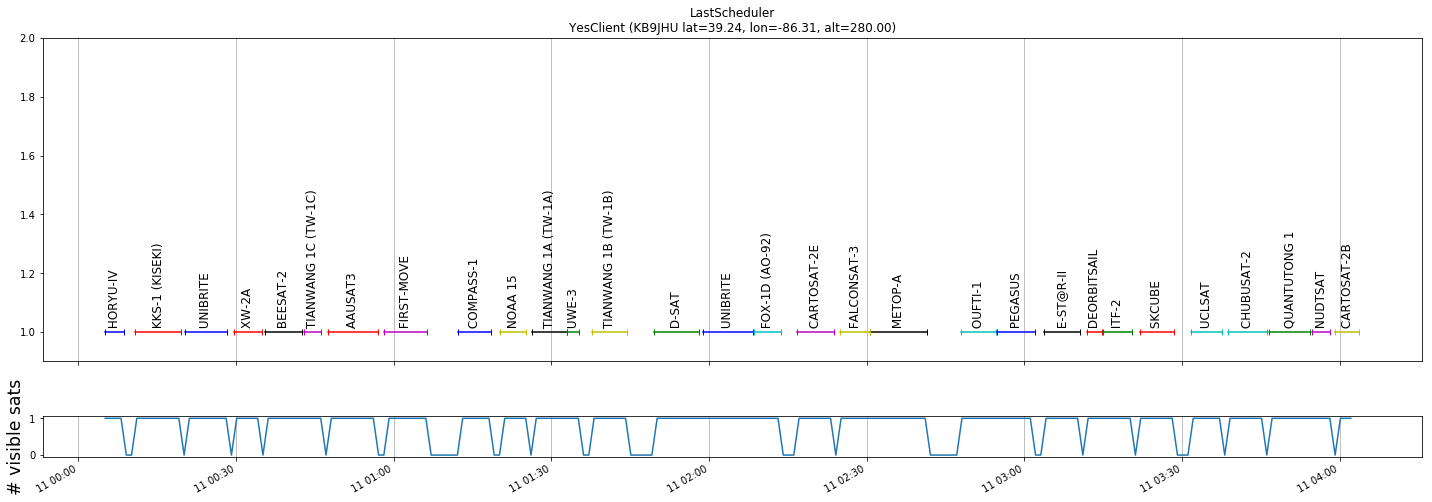

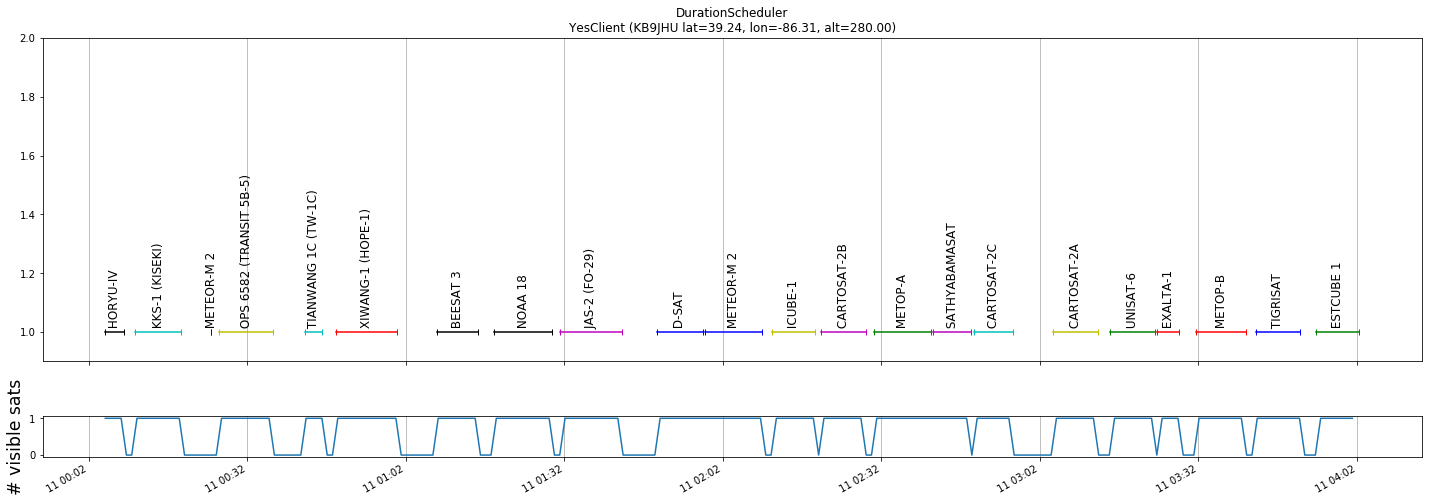

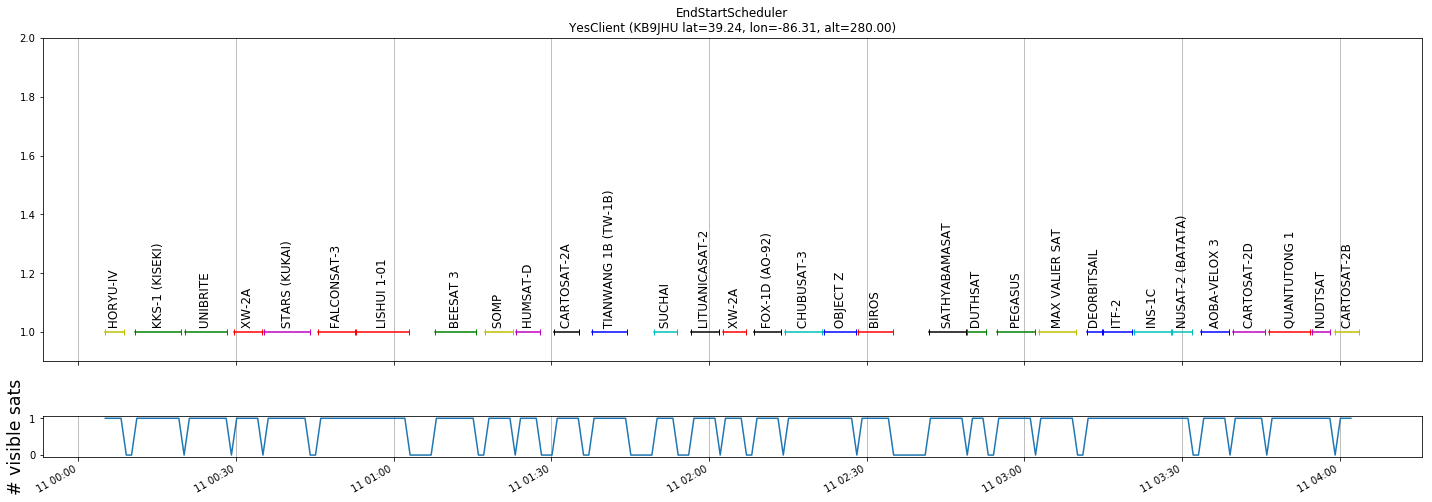

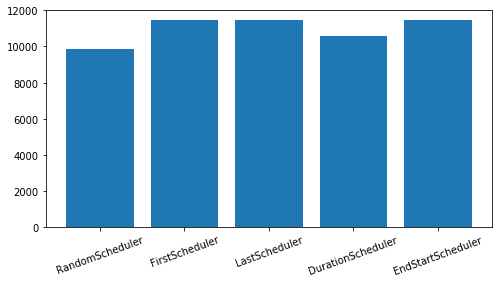

In [8]:
options = (
    schedulers.RandomScheduler,
    schedulers.FirstScheduler,
    schedulers.LastScheduler,
    schedulers.DurationScheduler,
    schedulers.EndStartScheduler,
)

names = []
busys = []
for sch in options:
    c = client.YesClient(gs)
    clients={gs['name']:c}

    s = sch(clients, satellites)
    s(passes)
    
    plot_result(c, sch.__name__)

    busys.append(c.busy_time())
    names.append(sch.__name__)

do_plot()
